In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/drive/MyDrive/pneumonia_detection/train'
test_path = '/content/drive/MyDrive/pneumonia_detection/test'
valid_path = '/content/drive/MyDrive/pneumonia_detection/val'

batch_size = 16
img_height = 500
img_width = 500

##Preparing the Data

 Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading The Images

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


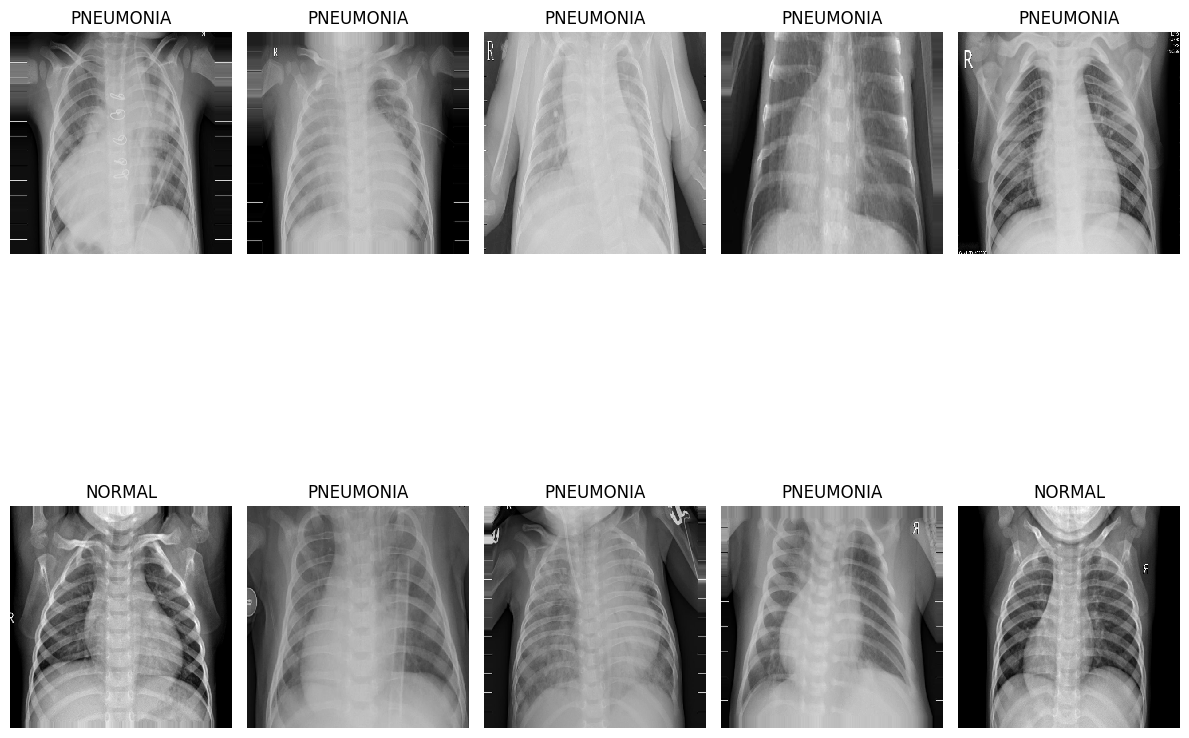

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

##Necessary imports

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

##CNN Architecture

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

##Visualize CNN model

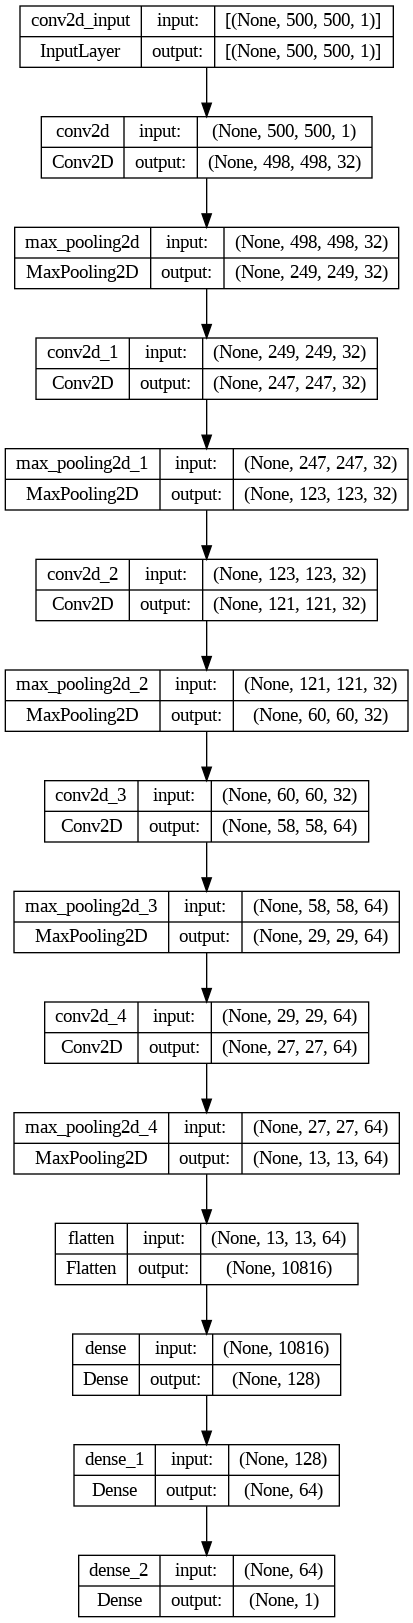

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

##Fit the model

####Defining Callback list

In [ ]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

####Assigning Class Weights

In [ ]:
import torch
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
unique_classes = np.unique(train.classes)
class_counts = np.bincount(train.classes)
total_samples = len(train.classes)

class_weights = {}
for cls in unique_classes:
    class_weight = total_samples / (len(unique_classes) * class_counts[cls])
    class_weights[cls] = class_weight


class_weights = [class_weights[i] for i in range(len(class_weights))]
class_weights = torch.FloatTensor(class_weights).cuda() if torch.cuda.is_available() else torch.FloatTensor(class_weights)
cw = dict(zip( np.unique(train.classes), class_weights))
cw_numeric = {cls: weight.item() for cls, weight in cw.items()}
cw_numeric

{0: 1.944817304611206, 1: 0.673032283782959}

####Train Model

In [ ]:
cnn.fit(train,epochs=50, validation_data=valid, class_weight=cw_numeric, callbacks=callbacks_list)

Epoch 1/50
326/326 [==============================] - 2062s 6s/step - loss: 0.4232 - accuracy: 0.7387 - val_loss: 1.1363 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/50
326/326 [==============================] - 147s 450ms/step - loss: 0.2510 - accuracy: 0.9066 - val_loss: 0.7617 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/50
326/326 [==============================] - 152s 465ms/step - loss: 0.2082 - accuracy: 0.9224 - val_loss: 0.7470 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/50
326/326 [==============================] - 148s 453ms/step - loss: 0.1973 - accuracy: 0.9275 - val_loss: 0.7874 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/50
326/326 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9323
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 150s 462ms/step - loss: 0.1804 - accuracy: 0.9323 - val_loss: 1.3567 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/50
326/326 [==========================

Looks like the EarlyStopping stopped at 14th epoch at val_loss =28.02% and val_accuracy = 93.75%.

<Axes: >

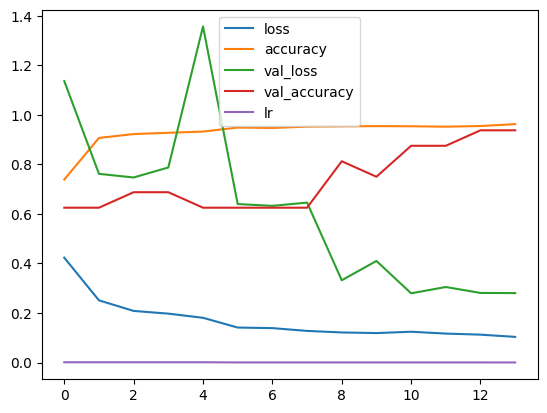

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 247s 6s/step - loss: 0.2597 - accuracy: 0.9199
The testing accuracy is : 91.98718070983887 %


The accuracy we are getting on Test dataset is of 92%

In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 5s 111ms/step


If the final layer's activation function is sigmoid, the model produces predictions between 0 and 1. To convert these into clear classifications (0 for normal and 1 for pneumonia), values from 0.5 to 1 are treated as 0, and values below 0.5 are considered as 1.

In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

##Confusion Matrix

<Axes: >

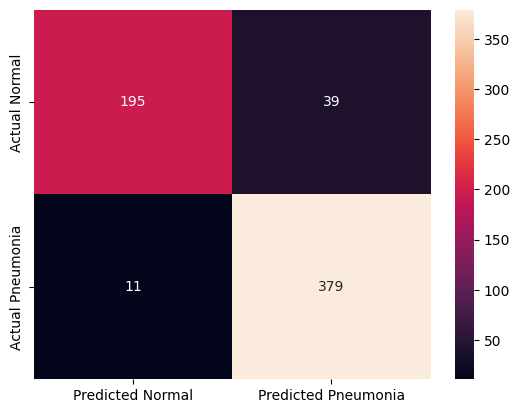

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.83      0.89       234
   PNEUMONIA       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624

